# **Виртуальная стажировка Сбер**

## Импорт библиотек

In [2]:
#pip install tsfresh
#pip install pmdarima

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tsfresh import extract_relevant_features, extract_features
from tsfresh.utilities.dataframe_functions import impute
from statsmodels.tsa.api import ExponentialSmoothing
 
import warnings
import statsmodels.api as sm
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime, timedelta

## Загрузка данных

In [4]:
df = pd.read_csv('data.csv', delimiter=';')

## Разведочный анализ данных

In [5]:
df.head()

,REPORTDATE,VALUE
0,30.12.2013,3457625638
1,31.12.2013,3417092149
2,01.01.2014,3417092149
3,02.01.2014,3417092149
4,03.01.2014,3417092149


в наших данных 2 столбца: дата и объем

In [6]:
#рассмотрим тип данных и отсутствующие значения
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   REPORTDATE  2111 non-null   object
 1   VALUE       2111 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.1+ KB


In [7]:
# пропусков нет, REPORTDATE переводим в to_datetime
df['REPORTDATE']=pd.to_datetime(df['REPORTDATE'], format='%d.%m.%Y')

In [8]:
#также рассмотрим описательную статистику столбца VALUE 
df.describe()

,VALUE
count,2.111000e+03
mean,3.389668e+10
std,1.875474e+10
min,3.282810e+09
25%,1.824160e+10
50%,3.021352e+10
75%,4.758339e+10
max,7.822860e+10


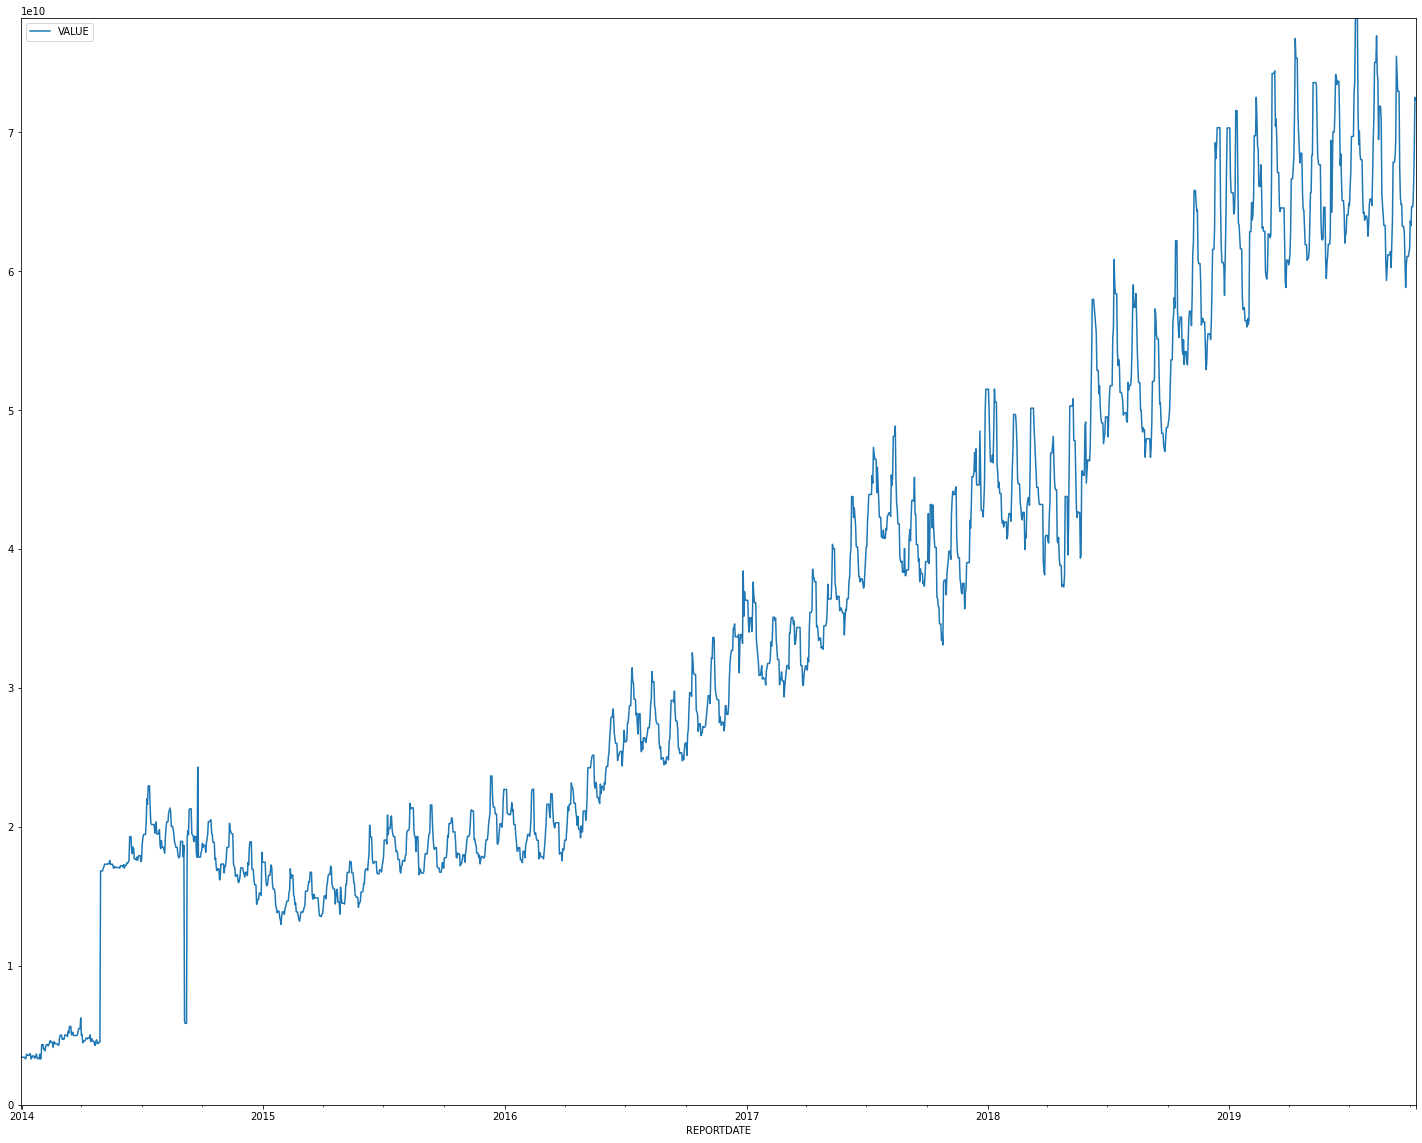

In [9]:
#строим график
df.plot(x='REPORTDATE', y='VALUE', kind='line', figsize=(25,20), ylim=(0, df['VALUE'].max()))

plt.show()

Из графика мы можем видеть, что выделяются как годичные периоды, где каждому году соответствует свой диапазон колебания объема(VALUE), так и месячные колебания, в виде пика и падения, повторяющихся 12 раз в год.
Также с увеличением VALUE увеличивается его дисперсия, а отрезок 2014-2015 выбивается из общей тенденции, что может сказаться на результатах

## Предобработка данных

In [10]:
#оставим данные с начала 2015г.
df = df[df['REPORTDATE'] >= '01.01.2015']
df.reset_index(inplace=True, drop=True)

In [11]:
df_ext=df.copy() #df_ext - расширенный df с доп. фичами

In [12]:
#добавим столбцы passed_days, day, month, year
df_ext["passed_days"] = (df["REPORTDATE"] - df.iloc[0,0]).dt.days
df_ext['day'] = df["REPORTDATE"].dt.dayofyear
df_ext['month'] = df["REPORTDATE"].dt.month
df_ext['year'] = df["REPORTDATE"].dt.year

df_ext.head()

,REPORTDATE,VALUE,passed_days,day,month,year
0,2015-01-01,17452425921,0,1,1,2015
1,2015-01-02,17452425921,1,2,1,2015
2,2015-01-03,17452425921,2,3,1,2015
3,2015-01-04,17452425921,3,4,1,2015
4,2015-01-05,16162817600,4,5,1,2015


## Линейная регрессия

В качестве базовой модели возмем линейную регрессию

In [13]:
#составим 2 регрессии: общую для всех данных и для тестовых данных
LR = LinearRegression() # общая регрессия
LR_2 = LinearRegression() # регрессия для тестовых данных
X = df_ext.drop(['VALUE', 'REPORTDATE'], axis=1)
y = df_ext['VALUE']

In [14]:
LR.fit(X,y)
LR_2.fit(X[:-350],y[:-350]) # [:-350] это 80% от df

LinearRegression()

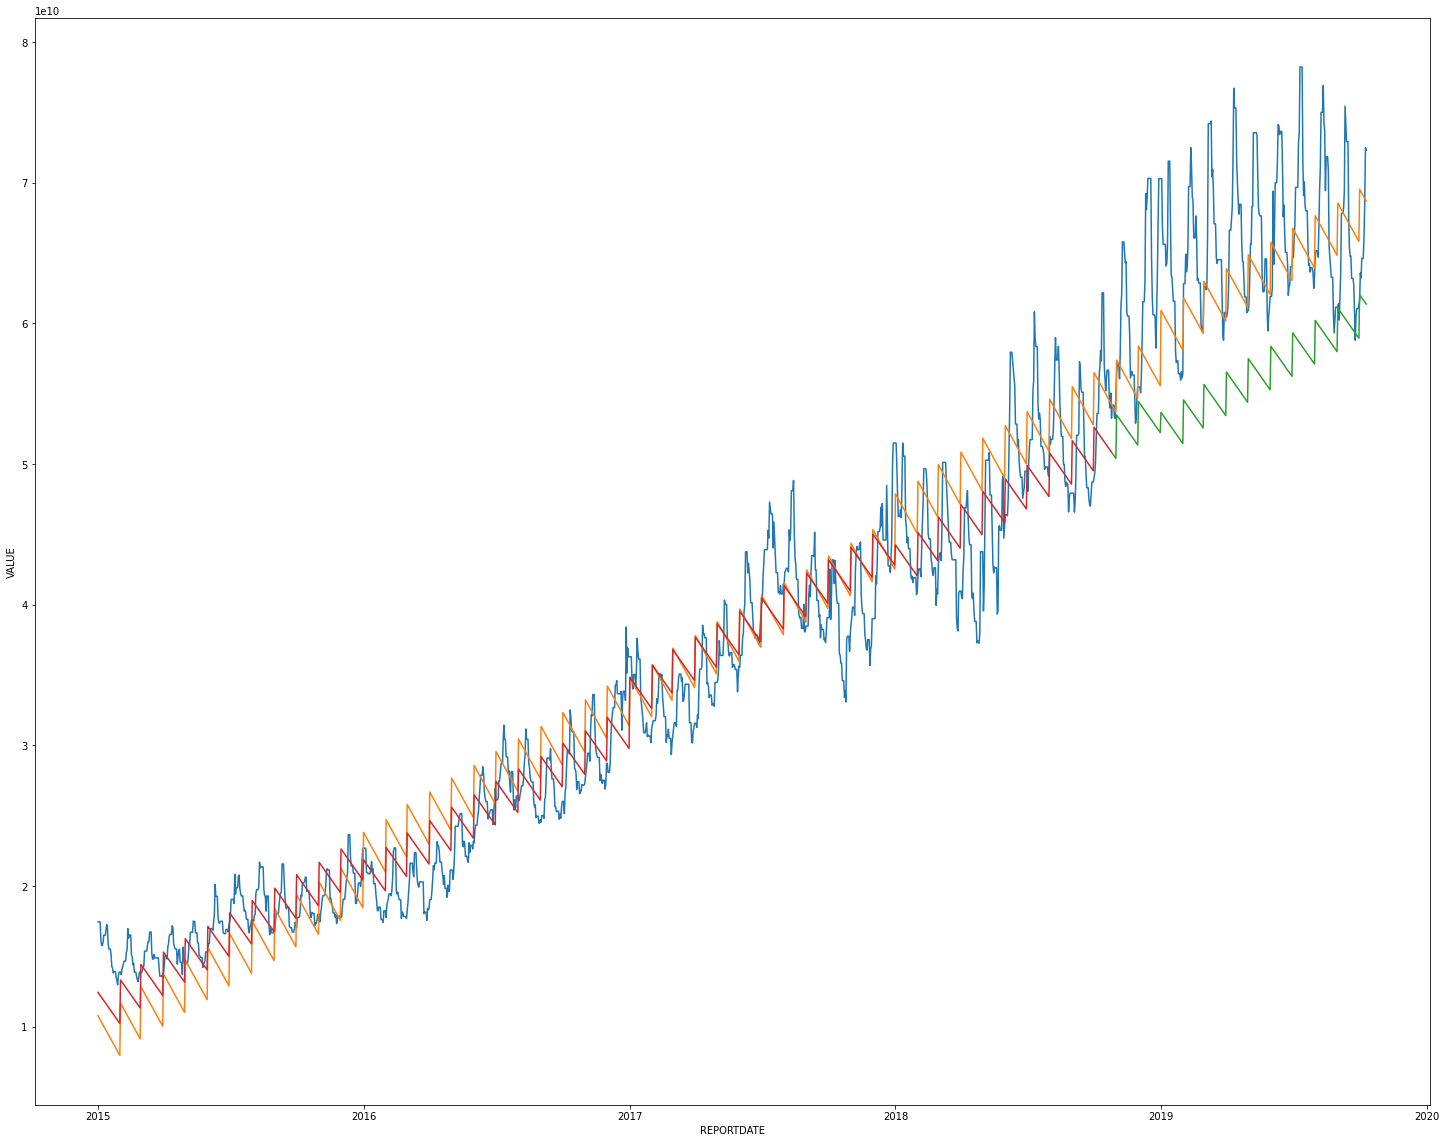

In [15]:
y_lin = LR.predict(X)
y_2_lin = LR_2.predict(X[-350:])
y_2_lin_train = LR_2.predict(X[:-350])

plt.figure(figsize=(25,20))
sns.lineplot(x=df_ext['REPORTDATE'], y=df_ext['VALUE'])
sns.lineplot(x=df_ext['REPORTDATE'], y=y_lin)
sns.lineplot(x=df_ext['REPORTDATE'][-350:], y=y_2_lin)
sns.lineplot(x=df_ext['REPORTDATE'][:-350], y=y_2_lin_train)
plt.show()

In [16]:
#rmse для общей линейной регрессии
rmse_lin_reg_total = mean_squared_error(df_ext['VALUE'], y_lin, squared=False)
rmse_lin_reg_total

4160832158.7812905

In [17]:
#rmse для тестовой выборки
rmse_lin_reg = mean_squared_error(df_ext['VALUE'][-350:], y_2_lin, squared=False)
rmse_lin_reg

10486241342.107698

Линейная регрессия показывает общую тенденцию, но как видно из графика, не годится для предсказания в рамках задачи, так как полученые значения не будут точными.

## Генерация признаков через tsfresh

Попробуем улучшить линейную регрессию добавив признаков с помощью tsfresh

In [18]:
X_tsfresh = extract_relevant_features(df_ext.drop(['VALUE', 'REPORTDATE'], axis=1), df_ext['VALUE'], column_id='passed_days')

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [01:05<00:00,  3.27s/it]


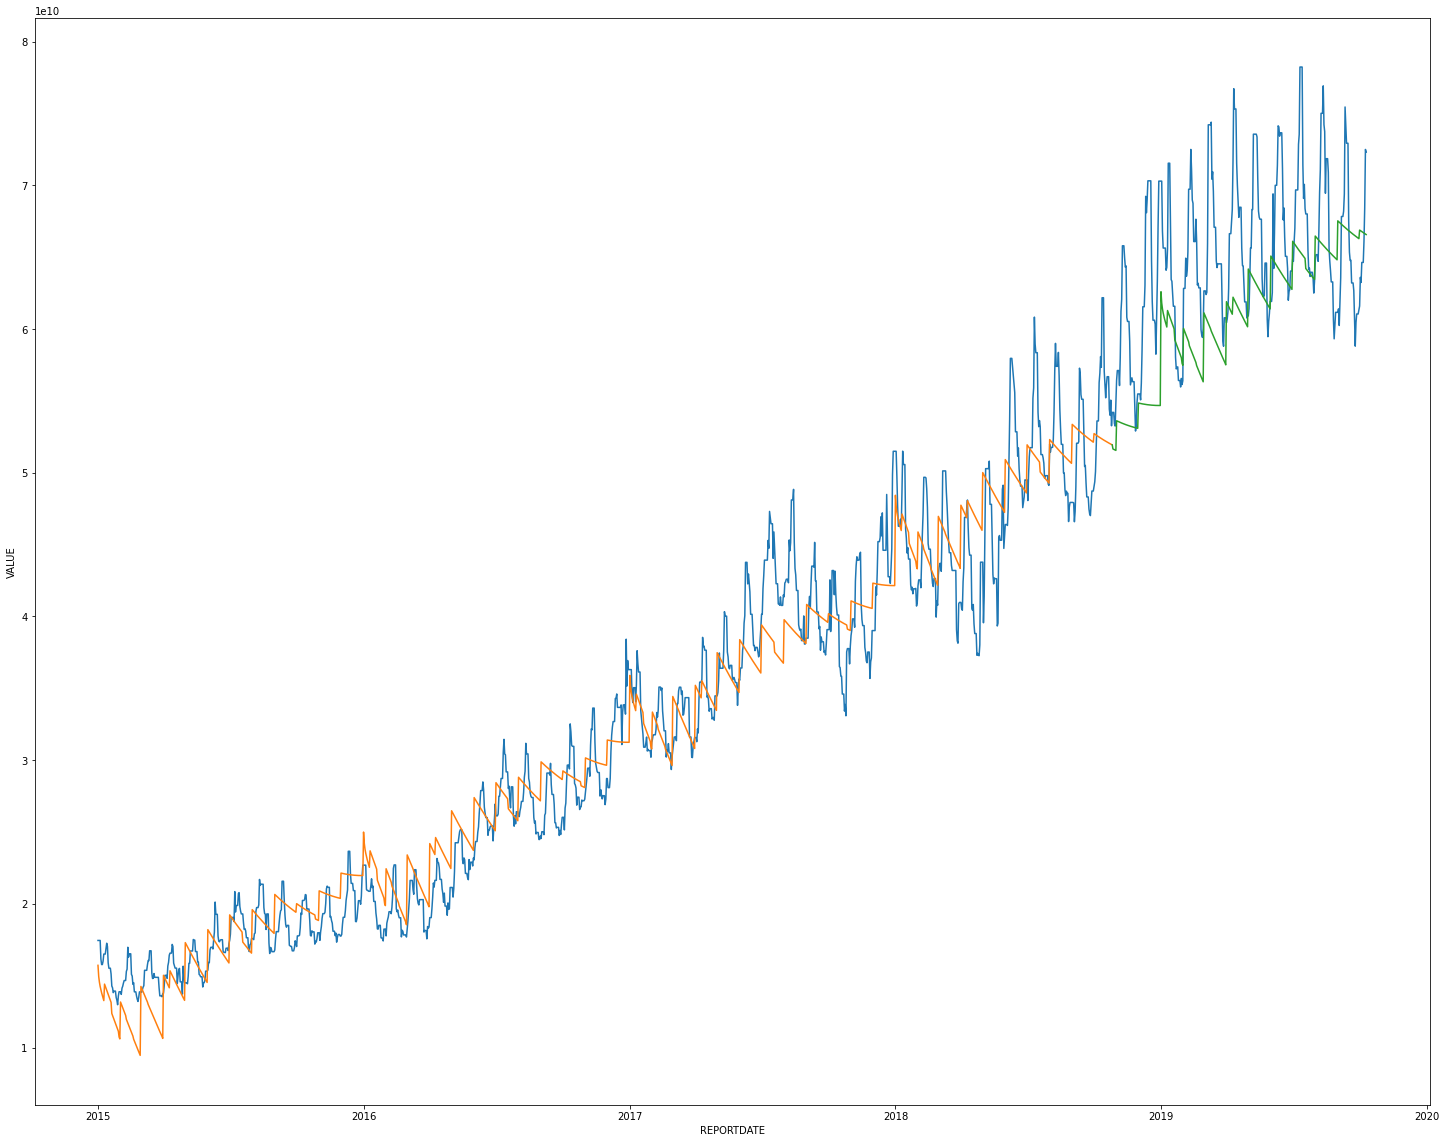

In [19]:
LR_extr = LinearRegression()
LR_extr.fit(X_tsfresh[:-350], df_ext['VALUE'][:-350])

y_pred_tsfresh = LR_extr.predict(X_tsfresh[-350:])
y_pred_train_tsfresh = LR_extr.predict(X_tsfresh[:-350])

plt.figure(figsize=(25,20))
sns.lineplot(x=df['REPORTDATE'], y=df['VALUE'])
sns.lineplot(x=df['REPORTDATE'][:-350], y=y_pred_train_tsfresh)
sns.lineplot(x=df['REPORTDATE'][-350:], y=y_pred_tsfresh)

plt.show()


In [20]:
#RMSE линейно регрессии с признаками из tsfresh
rmse_lin_tsfresh = mean_squared_error(df_ext['VALUE'][-350:], y_pred_tsfresh, squared=False)
rmse_lin_tsfresh

6550494892.474535

Наши предсказания улучшились как по графику так и по RMSE

## **Метод Хольта-Винтерса**

Для прогнозирования временного ряда воспользуемся методом Хольта-Винтерса

In [22]:
y_hat_avg = df[-350:].copy()
y_hat_avg.head()

,REPORTDATE,VALUE
1394,2018-10-26,54195909423
1395,2018-10-27,54195909423
1396,2018-10-28,54195909423
1397,2018-10-29,53419517125
1398,2018-10-30,53243496363


In [23]:
fit1 = ExponentialSmoothing(np.asarray(df_ext['VALUE'][:-350]), seasonal_periods=365, trend='add', seasonal='add',).fit()

C:\Python39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [24]:
y_hat_avg['Holt_Winters'] = fit1.forecast(len(df_ext[-350:]))

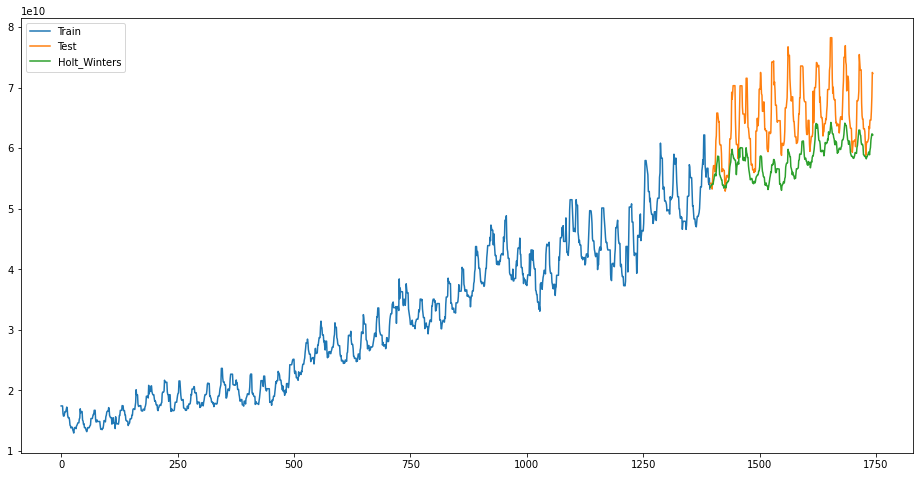

In [25]:
plt.figure(figsize=(16,8))
plt.plot(df_ext['VALUE'][:-350], label='Train')
plt.plot(df_ext['VALUE'][-350:], label='Test')
plt.plot(y_hat_avg['Holt_Winters'], label='Holt_Winters')
plt.legend(loc='best')
plt.show()

In [26]:
#RMSE метода Хольта-Винтерса
rmse_HW = mean_squared_error(df_ext['VALUE'][-350:], y_hat_avg['Holt_Winters'], squared=False)
rmse_HW

7977825308.711197

По RMSE метод Хольта-Винтерса оказался хуже линейно регрессии с tsfresh, но в нем фактически отсутствует пробитие стабильной части VALUE, что является важным условием задачи. 

## **ARIMA (SARIMAX)**

Воспользуемся моделью авторегрессии, SARIMAX

In [27]:
df_arima=df[['REPORTDATE', 'VALUE']]
df_arima.set_index('REPORTDATE', inplace=True)
train = df_arima[:-175]
test = df_arima[-175:]

In [ ]:
# "погасим" предупреждения
warnings.filterwarnings("ignore")
  
# настроим поиск параметров на обучающей выборке
parameter_search = auto_arima(train, start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 30, start_P = 0, seasonal = True,
                         d = None, D = 1, trace = True, error_action ='ignore', suppress_warnings = True,  stepwise = True)           #
 
# выведем результат
print(parameter_search.summary())

In [28]:
model = SARIMAX(train, 
                order = (2, 0, 1), 
                seasonal_order = (2, 1, 0, 30))

C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [29]:
result = model.fit()

C:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [30]:
start = len(train)
end = len(train) + len(test) - 1

In [31]:
predictions = result.predict(start, end)

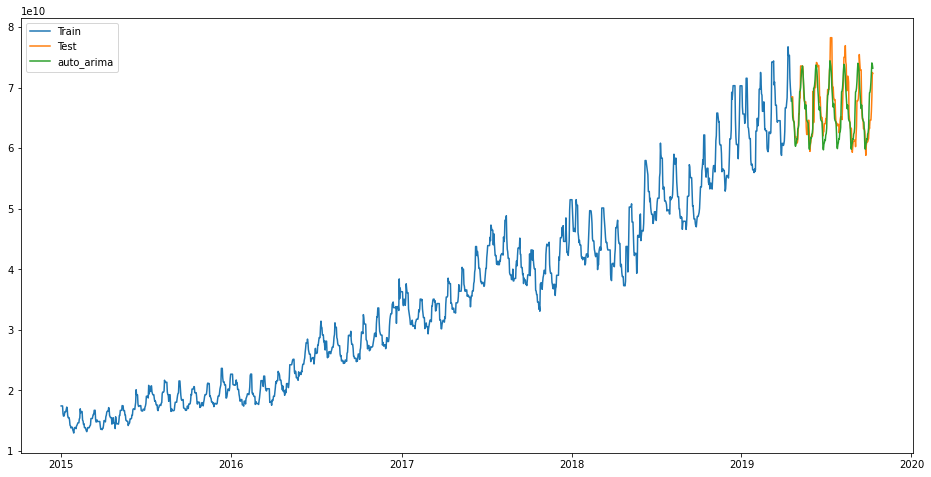

In [32]:
plt.figure(figsize=(16,8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predictions, label='auto_arima')
plt.legend(loc='best')
plt.show()

In [33]:
rmse_arimax = mean_squared_error(test['VALUE'], predictions, squared=False)
rmse_arimax

3000692758.565795

Модель построенная на SARIMAX имеет самую низкую RMSE из представленных, вдвое ниже линейной регрессии, а график предсказания соответствует графику данных.
Выберем эту модель для оценки обьема стабильной части средств на дату.

In [36]:
print('RMSE линейной регрессии с tsfresh: ', rmse_lin_tsfresh, '\n', \
     'RMSE модели Хольта-Винтерса: ', rmse_HW, '\n', \
     'RMSE SARIMAX: ', rmse_arimax, '\n')

RMSE линейной регрессии с tsfresh:  6550494892.474535 
 RMSE модели Хольта-Винтерса:  7977825308.711197 
 RMSE SARIMAX:  3000692758.565795 



## **FORECAST**

In [133]:
def model_forecast(date, period, history):
    """
    Функция предсказания оценивает объем стабильной части средств на дату date
    на горизонте period.
    
    Возвращает:
    stable_value - стабильный объем средств на дату,
    predictions - предсказание модели,
    stable_value_df - линия данных стабильного объема в формате DataFrame,
    history - история данных объема расчетных счетов физических лиц
    """
    period_days = int(period[:-1])*30
    
    # обрезаем историю до нудной даты
    if date in history.index: 
        indx = pd.to_datetime(date) - timedelta(1)
        history = history.loc[:indx]
    
    # строим модель и возвращаем минимальный объем стабильной части
    model = SARIMAX(history, 
                order = (2, 0, 1), 
                seasonal_order = (2, 1, 0, 30))
    result = model.fit()
    start = len(history)
    end = len(history) + period_days - 1
    
    predictions = result.predict(start, end)
    stable_value=min(predictions) # стабильный объем
    
    # данные для построения графика
    stable_value_df = pd.DataFrame({'VALUE':[stable_value, stable_value], 
                  'REPORTDATE':[date, pd.to_datetime(date) + timedelta(period_days)]})
    
    stable_value_df['REPORTDATE']=pd.to_datetime(stable_value_df['REPORTDATE'], format='%Y.%m.%d')
    stable_value_df.set_index('REPORTDATE', inplace=True)
    

    
    return stable_value, predictions, stable_value_df, history

In [134]:
stable_value, predictions, stable_value_df, history = model_forecast(date='2019-04-19', period='3M', history=df_arima)
print('Стабильный объем ДС: ', stable_value)

C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Стабильный объем ДС:  59716721091.74418


C:\Users\D899~1\AppData\Local\Temp/ipykernel_12956/1247765763.py:31: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  stable_value_df = pd.DataFrame({'VALUE':[stable_value, stable_value],


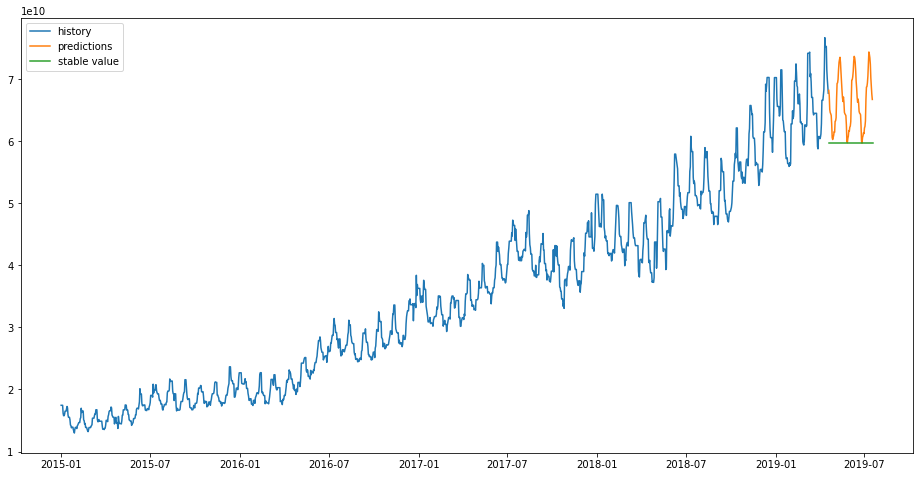

In [135]:
plt.figure(figsize=(16,8))
plt.plot(history, label='history')
plt.plot(predictions, label='predictions')
plt.plot(stable_value_df, label='stable value')
plt.legend(loc='best')
plt.show()

## **Вывод**

Для временного ряда в файле data.csv получилось построить модель, которая оценивает обьем стабильной части средств на дату, в примере это - 2019-04-19 с горизонтом в 3 месяца.
Модель построена на основе SARIMAX и есть возможность ее улучшить, подобрав более оптимальные гиперпараметры.